In [1]:
import numpy as np
import pandas as pd


from average_atom.core.average_atom import NeutralPseudoAtom as NPA
from average_atom.core.misc import jacobi_relaxation, sor
from average_atom.core.grids import NonUniformGrid
from average_atom.core.physics import ThomasFermi, FermiDirac

from importlib import reload
try:
    reload(physics)
    reload(grids)
    reload(average_atom_geometric)
#     reload(average_atom)
    reload(misc)
except NameError as e:
    from average_atom.core import physics as physics
    from average_atom.core import average_atom as average_atom
    from average_atom.core import misc as misc
    from average_atom.core import grids as grids
    print("Error: ",e)
except Exception as e:
    print("Unexpected error during reload")
    print(e)

import matplotlib.pyplot as plt

from hnc.hnc.constants import *
from hnc.hnc.misc import rs_from_n, n_from_rs

from scipy.interpolate import interp1d


import cProfile

plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["figure.dpi"] = 200
plt.rcParams['xtick.labelsize']=14


Error:  name 'physics' is not defined


In [2]:
# Aluminuma
name='Li'
A, Z = 6.941, 3 # Lithium
ρ_gpercc = 0.534 # solid Li density

ni_cc = ρ_gpercc/(A*amu_to_AU*AU_to_g)
ni_AU = ni_cc*invcc_to_AU
rs = rs_from_n(ni_AU)

####
R = 30*rs
rmin = rs/1000
ignore_vxc = True

aa_kwargs = {'initialize':True, 'gradient_correction':None, 'μ_init' : 0.158, 'Zstar_init' : 'More', 'rmin': rmin,'Npoints':600,
             'name':name, 'ignore_vxc':ignore_vxc, 'fixed_Zstar':False, 'iet_R_over_rs':R/rs, 'iet_N_bins':5000, 'use_full_ne_for_nf':False}

def get_solved_aa(Ti_AU, Te_AU):
    aa = NPA(Z, A, Ti_AU, Te_AU, rs, rs, **aa_kwargs)
    aa.solve_TF(verbose=True, picard_alpha=0.2, num_10folds_per_rs=0.5, tol=1e-7)
    aa.set_uii_eff()
    aa.iet.HNC_solve(iters_to_wait=1e5, tol=1e-12, verbose=False, num_iterations=1e5)
    aa.gii = interp1d(aa.iet.r_array*aa.rs, aa.iet.h_r_matrix[0,0]+1, bounds_error=False, fill_value='extrapolate')(aa.grid.xs)
    aa.make_ρi()
    return aa

In [3]:
Ti_eV, Te_eV = np.array([0.00396912, 0.00793824])*Ry_to_AU*AU_to_eV

Te_AU = Te_eV*eV_to_AU
Ti_AU = Ti_eV*eV_to_AU

aa_eq = get_solved_aa(Ti_AU, Ti_AU)
aa_neq = get_solved_aa(Ti_AU, Te_AU)

________________________
Generating NPA
Using More TF fit for initial Zstar = 0.919
	Intializing grid
	Creating Integral Equation Solver
Intialized Potentials and Densities
Beginning self-consistent electron solver.
_________________________________
__________________________________________
TF Iteration 0
	mu =     0.2698, change: 4.1256e+00 (converged=False)
	φe Err = -1.232e-06, φe change =  6.973e-01
	ne Err =  4.826e-01, ne change =  2.566e-03
	Q =  0.000e+00 ->  3.208e-01, 
	Zstar guess =  2.160e+00. Current Zstar:  1.167e+00 (converged=False)
	Change =  1.914e+00
__________________________________________
TF Iteration 1
	mu =     0.2149, change: 2.0348e-01 (converged=False)
	φe Err = -1.119e-06, φe change =  5.951e-02
	ne Err =  3.443e-01, ne change =  1.685e-03
	Q =  3.208e-01 ->  3.058e-01, 
	Zstar guess =  1.804e+00. Current Zstar:  1.295e+00 (converged=False)
	Change =  2.262e-01
__________________________________________
TF Iteration 2
	mu =     0.1988, change: 7.5199e-02 (

In [153]:
# fig, axs  = plt.subplots(1,2,figsize=(10,4))

# colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# short_distance_weight = np.exp(-(0.08*npa.kTF*npa.grid.xs)**4)
# for ax in axs:
#     # ax.plot(npa.iet.r_array*rs, npa.iet.h_r_matrix[0,0], color=colors[0], label=r"NPA: $u_Y$")
#     # ax.plot(npa.grid.xs, npa.gii-1, color=colors[0], label=r"NPA: $u_Y$")
#     # ax.plot(npa_2.grid.xs, npa_2.gii-1,'--', color=colors[0], label=r"NPA: $u_{AA}$",zorder=10)
#     ax.plot(aa.iet.r_array*rs, aa.iet.h_r_matrix[0,0],color=colors[1],  label=r"$u_{AA}$")
#     # ax.plot(npa.grid.xs, short_distance_weight*(npa.gii-1),'--',color=colors[3],  label=r"$u_Y$ damped")
    			

#     # ax.plot(aa.grid.xs, aa.gii-1,'--',color=colors[3],  label=r"$u_Y$")
#     ax.axvline(npa.iet.r_array[-1]*rs,color='k')
    
# ax = axs[0]
# ax.set_xlabel(r"$r/r_i$",fontsize=12)
# ax.set_ylabel("h(r)",fontsize=12)
# ax.set_xlim(0,3*rs)

# ax = axs[1]
# ax.set_xlabel(r"$r/r_i$",fontsize=12)
# ax.set_ylabel("h(r)",fontsize=12)
# ax.set_xscale('log')
# ax.set_xlim(0.5,None)
# ax.set_yscale('symlog', linthresh=1e-6)
# for ax in axs:
#     ax.legend(fontsize=12)
#     ax.tick_params(labelsize=12)


# plt.tight_layout()



In [154]:
# aa.make_plot_bound_free()

In [155]:
# aa.make_charge_plot()

### Compare with Cleroin 2015 OFDFT

In [5]:
from pandas import read_csv

QE_data_eq = read_csv("/home/zach/plasma/average_atom/jupyter/Benchmarks/gii_QE_nvt_Te=0.054eV_Ti=0.054eV.dat", delim_whitespace=True, header=0)
QE_data_neq = read_csv("/home/zach/plasma/average_atom/jupyter/Benchmarks/gii_QE_nvt_Te=0.108eV_Ti=0.054eV.dat", delim_whitespace=True, header=0)

##### $g_{ii}(r)$

/tmp/ipykernel_33193/131053290.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot(QE_data_eq['r[AU]']/rs, QE_data_eq['g(r)'],'k-', color=color_cycle[1], label=r"DFT $T_e = T_i$")
/tmp/ipykernel_33193/131053290.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(QE_data_neq['r[AU]']/rs, QE_data_neq['g(r)'],'k--', color=color_cycle[1], label=r"DFT $T_e = 2 T_i$")


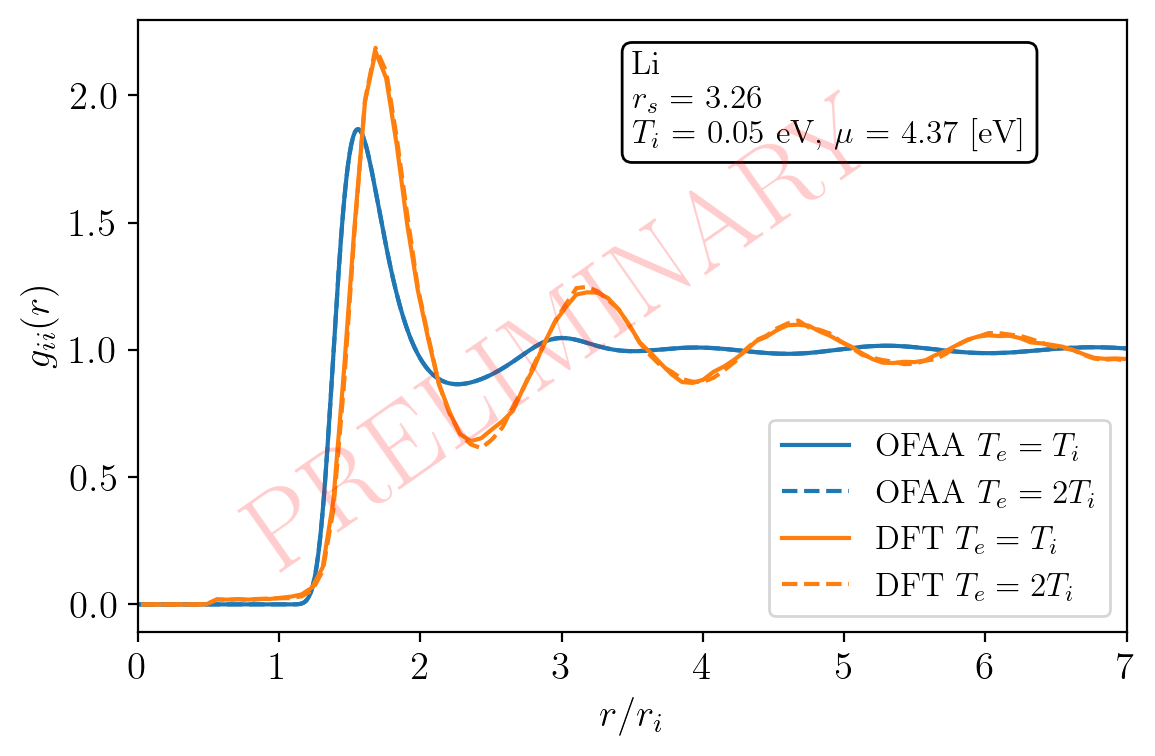

In [38]:
fig, ax = plt.subplots()

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

ax.plot(aa_eq.iet.r_array, aa_eq.iet.h_r_matrix[0,0]+1, color=color_cycle[0], label=r"OFAA $T_e = T_i$")
ax.plot(aa_neq.iet.r_array, aa_neq.iet.h_r_matrix[0,0]+1,'--' ,color=color_cycle[0], label=r"OFAA $T_e = 2 T_i$")
ax.plot(QE_data_eq['r[AU]']/rs, QE_data_eq['g(r)'],'k-', color=color_cycle[1], label=r"DFT $T_e = T_i$")
ax.plot(QE_data_neq['r[AU]']/rs, QE_data_neq['g(r)'],'k--', color=color_cycle[1], label=r"DFT $T_e = 2 T_i$")
# ax.errorbar(QE_data_1['r[AU]']/rs, QE_data_1['g(r)'],QE_data_1['σ(r)'], label="QE" ,fmt='^',color='k')

# make textbox
text = ("{0}\n".format(aa_eq.name)+ 
    r"$r_s$ = " + "{0}\n".format(np.round(aa_eq.rs,2))  +
        r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa_eq.Ti*AU_to_eV) +
        r"$\mu$ = " + "{0:0.2f} [eV]".format(aa_eq.μ*AU_to_eV))

props = dict(boxstyle='round', facecolor='w')
ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)
ax.text(0.1,0.1, 'PRELIMINARY', rotation=35,color='r',alpha=0.2,fontsize=40, transform=ax.transAxes)#, verticalalignment='top', horizontalalignment='left')
# ax.axvline(rs, color='k', label=r"$\pi/r_i$", alpha=0.3)
# ax.axvline(2*aa.kF, color='r', label=r"$2 k_F$", alpha=0.3)

ax.set_xlim(0,7)
# ax.set_ylim(0,None)
ax.set_xlabel(r"$r/r_i$")
ax.set_ylabel(r"$g_{ii}(r)$")
ax.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.savefig("gii_QE.png")

##### $S_{ii}(k)$

In [139]:
# fig, ax = plt.subplots()

# color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# ax.plot(aa.iet.k_array/rs, aa.iet.S_k_matrix[0,0],'--.', label="OFAA")
# # ax.plot(JC_2015_data['k[1/Ang]']/Angstrom_to_AU, JC_2015_data['S_ii(k)'],'k.', label="OFMD Clerouin et al. 2015" )

# # make textbox
# text = ("{0}\n".format(aa.name)+ 
#     r"$r_s$ = " + "{0}\n".format(np.round(aa.rs,2))  +
#         r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa.Ti*AU_to_eV) +
#         r"$T_e$ = " + "{0:0.2f} eV\n".format(aa.Te*AU_to_eV) +
#         r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

# props = dict(boxstyle='round', facecolor='w')
# ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)

# # make textbox
# text = ("{0}\n".format(aa.name)+ 
#     r"$r_s$ = " + "{0}\n".format(np.round(aa.rs,2))  +
#         r"$T_i$ = " + "{0:0.2f} eV,   ".format(aa.Ti*AU_to_eV) +
#         r"$T_e$ = " + "{0:0.2f} eV\n".format(aa.Te*AU_to_eV) +
#         r"$\mu$ = " + "{0:0.2f} [eV]".format(aa.μ*AU_to_eV))

# props = dict(boxstyle='round', facecolor='w')
# ax.text(0.5,0.95, text, fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='left', bbox=props)

# ax.axvline(π/rs, color='k', label=r"$\pi/r_i$", alpha=0.3)
# ax.axvline(2*aa.kF, color='r', label=r"$2 k_F$", alpha=0.3)

# ax.set_xlim(0,10)
# ax.set_ylim(0,None)
# ax.set_xlabel(r"$k [au]$")
# ax.set_ylabel(r"$S_{ii}(k)$")
# ax.legend(fontsize=12, loc='lower right')